In [1]:
import sys
!{sys.executable} -m pip install gensim
!pip install keras-preprocessing

In [2]:
!pip3 install keras-preprocessing

In [3]:
!pip3 install tensorflow

In [4]:
import logging
import pandas as pd
import numpy as np
import time

In [5]:
import tensorflow as tf

In [6]:

from numpy import random
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from bs4 import BeautifulSoup
%matplotlib inline
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import SpatialDropout1D, LSTM, Bidirectional
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.callbacks import ModelCheckpoint, EarlyStopping
import io
import re
import string
import tqdm
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Helper functions

In [7]:
def print_example_with_a_given_index(index):
    example = df[df.index == index][['post', 'tags']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Tag:', example[1])


def data_cleansing(text):

    REGEX_ITEMS_TO_BE_REPLACED_BY_SPACE = re.compile('[/(){}\[\]\|@,;]')
    REGEX_ITEMS_TO_BE_DELETED = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))

    text = BeautifulSoup(text, "lxml").text
    text = text.lower()
    text = REGEX_ITEMS_TO_BE_REPLACED_BY_SPACE.sub(' ', text)
    text = REGEX_ITEMS_TO_BE_DELETED.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwords
    return text

def count_words_in_a_dataset(dataframe):
    count = dataframe['post'].apply(lambda x: len(x.split(' '))).sum()
    print("Words count:", count)
    return count


# Loading data

In [8]:
df = pd.read_csv('stack-overflow-data.csv')
df = df[pd.notnull(df['tags'])]
print(df.head(10))
count_words_in_a_dataset(df)



                                                post           tags
0  what is causing this behavior  in our c# datet...             c#
1  have dynamic html load as if it was in an ifra...        asp.net
2  how to convert a float value in to min:sec  i ...    objective-c
3  .net framework 4 redistributable  just wonderi...           .net
4  trying to calculate and print the mean and its...         python
5  how to give alias name for my website  i have ...        asp.net
6  window.open() returns null in angularjs  it wo...      angularjs
7  identifying server timeout quickly in iphone  ...         iphone
8  unknown method key  error in rails 2.3.8 unit ...  ruby-on-rails
9  from the include  how to show and hide the con...      angularjs
Words count: 10286120


10286120

# Ensuring dataset is balanced

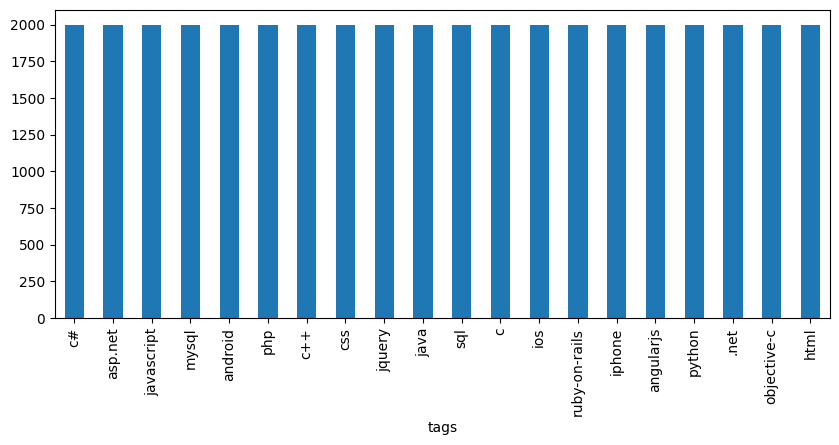

In [9]:
plt.figure(figsize=(10,4))
df.tags.value_counts().plot(kind='bar');

In [10]:
print_example_with_a_given_index(10)
count_words_in_a_dataset(df)

when we need interface c# <blockquote>    <strong>possible duplicate:</strong><br>   <a href= https://stackoverflow.com/questions/240152/why-would-i-want-to-use-interfaces >why would i want to use interfaces </a>   <a href= https://stackoverflow.com/questions/9451868/why-i-need-interface >why i need interface </a>    </blockquote>     i want to know where and when to use it     for example    <pre><code>interface idemo {  // function prototype  public void show(); }  // first class using the interface class myclass1 : idemo {  public void show()  {   // function body comes here   response.write( i m in myclass );  }  }  // second class using the interface class myclass2 : idemo {  public void show()   {   // function body comes here   response.write( i m in myclass2 );   response.write( so  what  );  } </code></pre>   these two classes has the same function name with different body. this can be even achieved without interface. then why we need an interface where and when to use it
Tag:

10286120

# Data Cleansing

In [11]:
df['post'] = df['post'].apply(data_cleansing)
print_example_with_a_given_index(10)
count_words_in_a_dataset(df)
cnt = Counter((" ".join(df['post'].values.tolist()).split(' ')))
print(len(cnt))

<ipython-input-7-aad356aecece>:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


need interface c# possible duplicate would want use interfaces need interface want know use example interface idemo function prototype public void show first class using interface class myclass1 idemo public void show function body comes responsewrite myclass second class using interface class myclass2 idemo public void show function body comes responsewrite myclass2 responsewrite two classes function name different body even achieved without interface need interface use
Tag: c#
Words count: 3424155
279312


# Train and test sets

In [12]:
samples = df.post
labels = df.tags
X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size=0.3, random_state = 42)
classes = df['tags'].unique().tolist()


# Machine Specs

In [ ]:
!cat /proc/meminfo
!cat /proc/cpuinfo
!nvidia-smi

MemTotal:       98805324 kB
MemFree:        33537624 kB
MemAvailable:   48136188 kB
Buffers:          313280 kB
Cached:         14709856 kB
SwapCached:      7084560 kB
Active:         49445696 kB
Inactive:       13208712 kB
Active(anon):   47565736 kB
Inactive(anon):    68884 kB
Active(file):    1879960 kB
Inactive(file): 13139828 kB
Unevictable:        1876 kB
Mlocked:               0 kB
SwapTotal:      209715196 kB
SwapFree:       198925660 kB
Zswap:                 0 kB
Zswapped:              0 kB
Dirty:                20 kB
Writeback:             0 kB
AnonPages:      47398736 kB
Mapped:           760308 kB
Shmem:              3388 kB
KReclaimable:     509520 kB
Slab:             862200 kB
SReclaimable:     509520 kB
SUnreclaim:       352680 kB
KernelStack:       25488 kB
PageTables:       160916 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    259117856 kB
Committed_AS:   63825868 kB
VmallocTotal:   3

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


classes = df['tags'].unique().tolist()


nb = Pipeline([('vect', CountVectorizer()), ('clf', MultinomialNB())])
start_time = time.perf_counter()
nb.fit(X_train, y_train)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


from sklearn.metrics import classification_report
start_time = time.perf_counter()
y_pred = nb.predict(X_test)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes))


The model took 3.2627408960834146 seconds to train on 28000 items. Avg inference time was 0.00011652646057440766
The model took 0.6164143590722233 seconds to predidct 12000 items. Avg inference time was 5.136786325601861e-05
accuracy 0.7266666666666667
               precision    recall  f1-score   support

           c#       0.68      0.60      0.63       613
      asp.net       0.92      0.86      0.89       620
  objective-c       0.82      0.95      0.88       587
         .net       0.77      0.74      0.75       586
       python       0.78      0.82      0.80       599
    angularjs       0.66      0.55      0.60       589
       iphone       0.69      0.81      0.74       594
ruby-on-rails       0.73      0.84      0.78       610
          ios       0.65      0.53      0.58       617
            c       0.52      0.69      0.60       587
          sql       0.76      0.36      0.49       611
         java       0.74      0.80      0.77       594
       jquery       0.80      0

<Axes: >

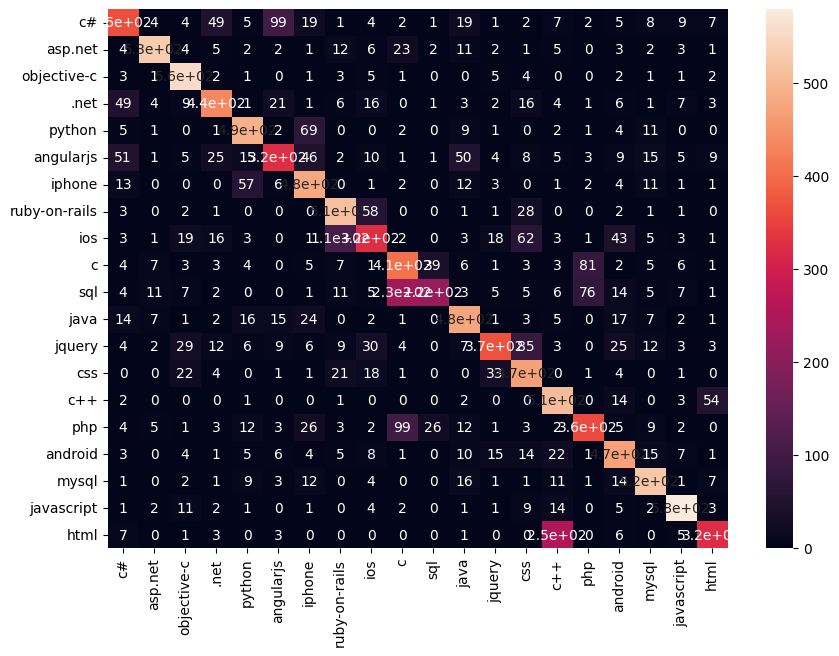

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
start_time = time.perf_counter()
logreg.fit(X_train, y_train)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")

start_time = time.perf_counter()
y_pred = logreg.predict(X_test)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes))

The model took 107.89971986808814 seconds to train on 28000 items. Avg inference time was 0.0038535614238602908
The model took 0.7481325860135257 seconds to predidct 12000 items. Avg inference time was 6.234438216779381e-05
accuracy 0.7771666666666667
               precision    recall  f1-score   support

           c#       0.65      0.63      0.64       613
      asp.net       0.91      0.90      0.90       620
  objective-c       0.97      0.94      0.96       587
         .net       0.73      0.75      0.74       586
       python       0.78      0.82      0.80       599
    angularjs       0.60      0.56      0.58       589
       iphone       0.77      0.76      0.76       594
ruby-on-rails       0.79      0.87      0.83       610
          ios       0.68      0.71      0.70       617
            c       0.62      0.55      0.58       587
          sql       0.62      0.63      0.62       611
         java       0.82      0.82      0.82       594
       jquery       0.75      0.

<Axes: >

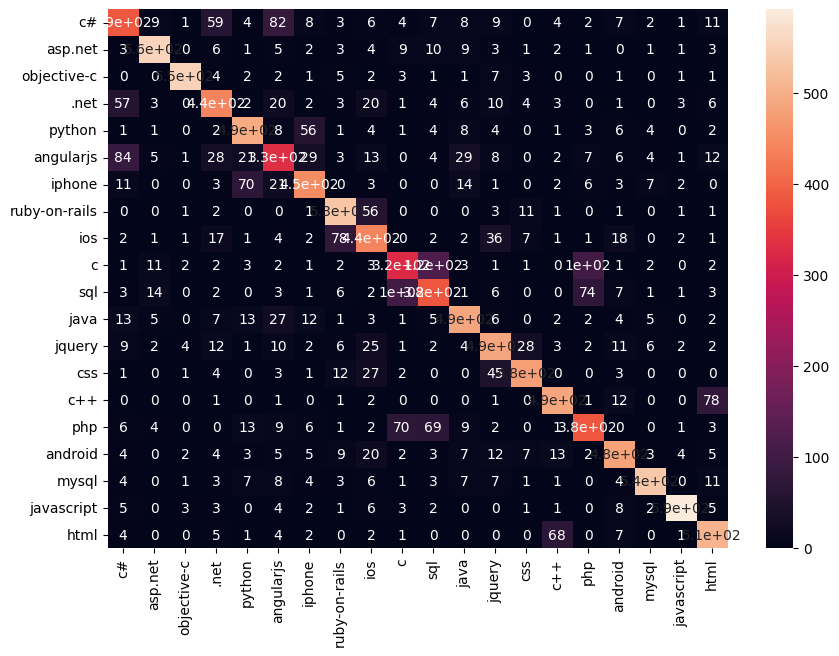

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# CNN

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)


Found 247039 unique tokens.
Shape of data tensor: (40000, 250)
Shape of label tensor: (40000, 20)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [ ]:
def create_cnn():
    textcnnmodel = Sequential()
    textcnnmodel.add(layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    textcnnmodel.add(SpatialDropout1D(0.2))
    textcnnmodel.add(layers.Conv1D(200, 20, activation='relu'))
    textcnnmodel.add(layers.GlobalMaxPooling1D())
    textcnnmodel.add(layers.Dense(20, activation='softmax'))
    textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    textcnnmodel.summary()

    return textcnnmodel

In [ ]:
cnn1 = create_cnn()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 5
batch_size = 64
start_time = time.perf_counter()
history = cnn1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 95s 236ms/step - accuracy: 0.2440 - loss: 0.2207 - val_accuracy: 0.7711 - val_loss: 0.0644
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 85s 214ms/step - accuracy: 0.8317 - loss: 0.0510 - val_accuracy: 0.8050 - val_loss: 0.0551
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 89s 226ms/step - accuracy: 0.9008 - loss: 0.0336 - val_accuracy: 0.8057 - val_loss: 0.0553
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 85s 214ms/step - accuracy: 0.9479 - loss: 0.0210 - val_accuracy: 0.8025 - val_loss: 0.0591
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 86s 219ms/step - accuracy: 0.9794 - loss: 0.0115 - val_accuracy: 0.7971 - val_loss: 0.0640
The model took 439.2430551480502 seconds to train on 28000 items. Avg inference time was 0.01568725196957322


In [ ]:
accr = cnn1.evaluate(X_test, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8129 - loss: 0.0618
Test set
  Loss: 0.062
  Accuracy: 0.813


In [ ]:
start_time = time.perf_counter()
y_pred = cnn1.predict(X_test)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)


print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred, target_names=classes))

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step
The model took 9.959233807167038 seconds to predidct 12000 items. Avg inference time was 0.0008299361505972532
accuracy 0.8125833333333333
               precision    recall  f1-score   support

           c#       0.74      0.70      0.72       613
      asp.net       0.93      0.91      0.92       620
  objective-c       0.98      0.96      0.97       587
         .net       0.81      0.81      0.81       586
       python       0.86      0.84      0.85       599
    angularjs       0.68      0.69      0.68       589
       iphone       0.78      0.81      0.79       594
ruby-on-rails       0.83      0.88      0.85       610
          ios       0.73      0.74      0.73       617
            c       0.65      0.67      0.66       587
          sql       0.74      0.62      0.67       611
         java       0.85      0.84      0.84       594
       jquery       0.80      0.83      0.82       619
          css       0.86      0.86      0.86   

<Axes: >

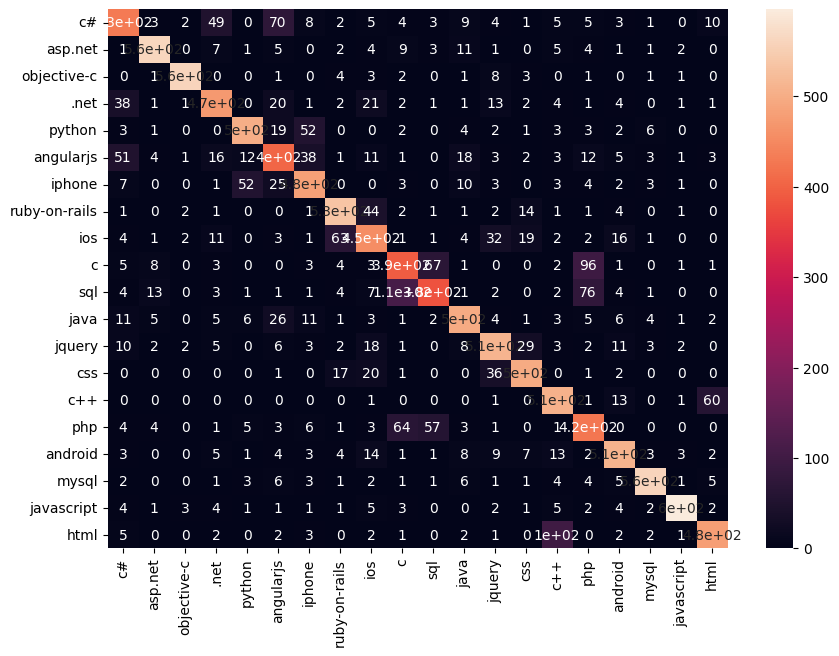

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(Y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
del cnn1

# LSTM

In [ ]:
def create_lstm():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

lstm1 = create_lstm()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 3
batch_size = 64
start_time = time.perf_counter()
history = lstm1.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/3
394/394 ━━━━━━━━━━━━━━━━━━━━ 142s 351ms/step - accuracy: 0.1534 - loss: 2.6315 - val_accuracy: 0.3171 - val_loss: 1.8640
Epoch 2/3
394/394 ━━━━━━━━━━━━━━━━━━━━ 141s 357ms/step - accuracy: 0.3648 - loss: 1.7699 - val_accuracy: 0.4232 - val_loss: 1.5372
Epoch 3/3
394/394 ━━━━━━━━━━━━━━━━━━━━ 135s 342ms/step - accuracy: 0.4899 - loss: 1.4108 - val_accuracy: 0.5629 - val_loss: 1.2764
The model took 417.16076020896435 seconds to train on 28000 items. Avg inference time was 0.014898598578891585


In [ ]:
start_time = time.perf_counter()
y_pred = lstm1.predict(X_test)
y_pred=np.argmax(y_pred, axis=1)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred, target_names=classes))

375/375 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step
The model took 27.958771768026054 seconds to predidct 12000 items. Avg inference time was 0.0023298976473355047
accuracy 0.55275
               precision    recall  f1-score   support

           c#       0.60      0.43      0.50       613
      asp.net       0.76      0.82      0.79       620
  objective-c       0.72      0.90      0.80       587
         .net       0.47      0.21      0.29       586
       python       0.56      0.75      0.64       599
    angularjs       0.37      0.12      0.18       589
       iphone       0.44      0.22      0.29       594
ruby-on-rails       0.72      0.81      0.76       610
          ios       0.58      0.55      0.56       617
            c       0.38      0.53      0.45       587
          sql       0.52      0.36      0.43       611
         java       0.56      0.57      0.57       594
       jquery       0.61      0.50      0.55       619
          css       0.75      0.60      0.67       574
  

<Axes: >

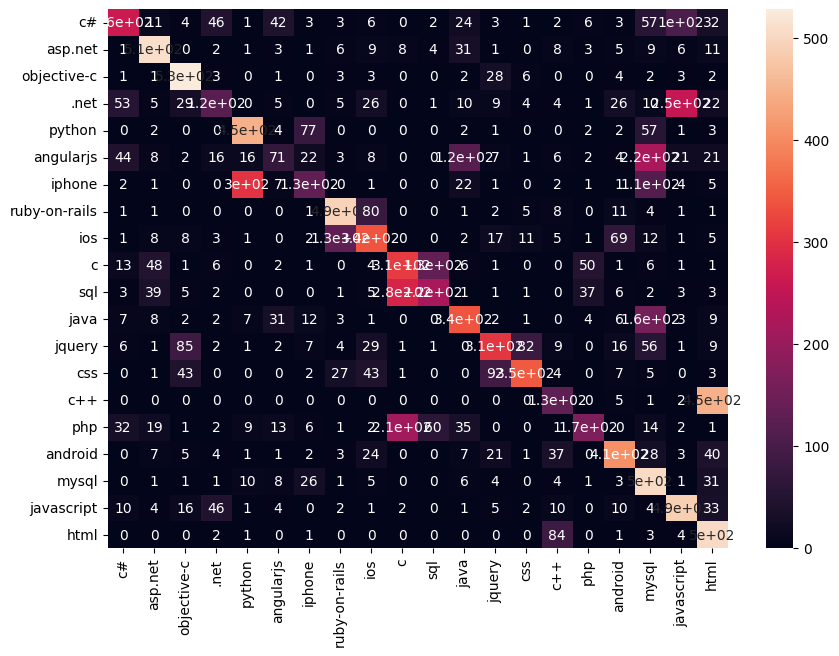

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(Y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
del lstm1

# Load and check Word2Vec
Trained on Google News dataset

In [16]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


wv.fill_norms()
from itertools import islice
list(islice(wv.key_to_index, 60, 70))

['than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into']

In [17]:
def word_averaging(wv, words):
    all_words, mean = set(), []

    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.vectors[wv.key_to_index[word]])
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)

        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


In [18]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [ ]:
train_tokenized.shape

(28000,)

# Naive Bayes with Word2Vec

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler



nb1 =  Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
start_time = time.perf_counter()
nb1.fit(X_train_word_average, y_train)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


from sklearn.metrics import classification_report
start_time = time.perf_counter()
y_pred = nb1.predict(X_test_word_average)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes))

The model took 0.1255118220578879 seconds to train on 28000 items. Avg inference time was 4.482565073495997e-06
The model took 0.02819656813517213 seconds to predidct 12000 items. Avg inference time was 2.349714011264344e-06
accuracy 0.42291666666666666
               precision    recall  f1-score   support

           c#       0.45      0.44      0.44       613
      asp.net       0.74      0.32      0.45       620
  objective-c       0.55      0.29      0.38       587
         .net       0.27      0.48      0.34       586
       python       0.43      0.65      0.52       599
    angularjs       0.25      0.25      0.25       589
       iphone       0.39      0.31      0.35       594
ruby-on-rails       0.50      0.60      0.54       610
          ios       0.37      0.36      0.37       617
            c       0.35      0.38      0.37       587
          sql       0.45      0.39      0.42       611
         java       0.44      0.39      0.41       594
       jquery       0.62      

<Axes: >

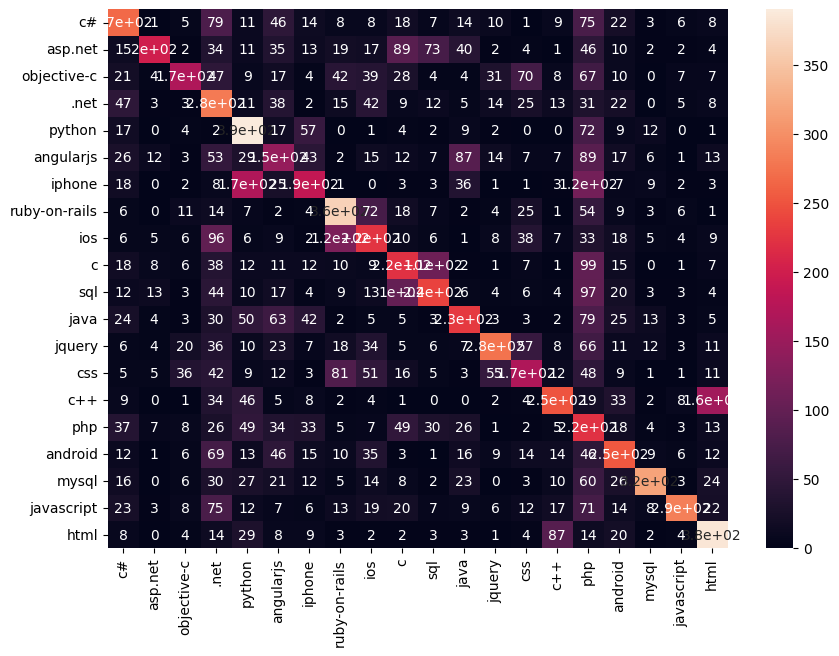

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Logistic Regression with Word2vec

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=1000)
start_time = time.perf_counter()
logreg = logreg.fit(X_train_word_average, train['tags'])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")

start_time = time.perf_counter()
y_pred = logreg.predict(X_test_word_average)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

print('accuracy %s' % accuracy_score(y_pred, test.tags))
print(classification_report(test.tags, y_pred,target_names=classes))

The model took 24.219351124949753 seconds to train on 28000 items. Avg inference time was 0.0008649768258910626
The model took 0.006474206922575831 seconds to predidct 12000 items. Avg inference time was 5.395172435479859e-07
accuracy 0.6443333333333333
               precision    recall  f1-score   support

           c#       0.62      0.58      0.60       613
      asp.net       0.75      0.77      0.76       620
  objective-c       0.67      0.66      0.67       587
         .net       0.52      0.52      0.52       586
       python       0.71      0.75      0.73       599
    angularjs       0.43      0.41      0.42       589
       iphone       0.61      0.61      0.61       594
ruby-on-rails       0.75      0.80      0.77       610
          ios       0.60      0.61      0.61       617
            c       0.54      0.53      0.54       587
          sql       0.58      0.52      0.55       611
         java       0.61      0.61      0.61       594
       jquery       0.67      

<Axes: >

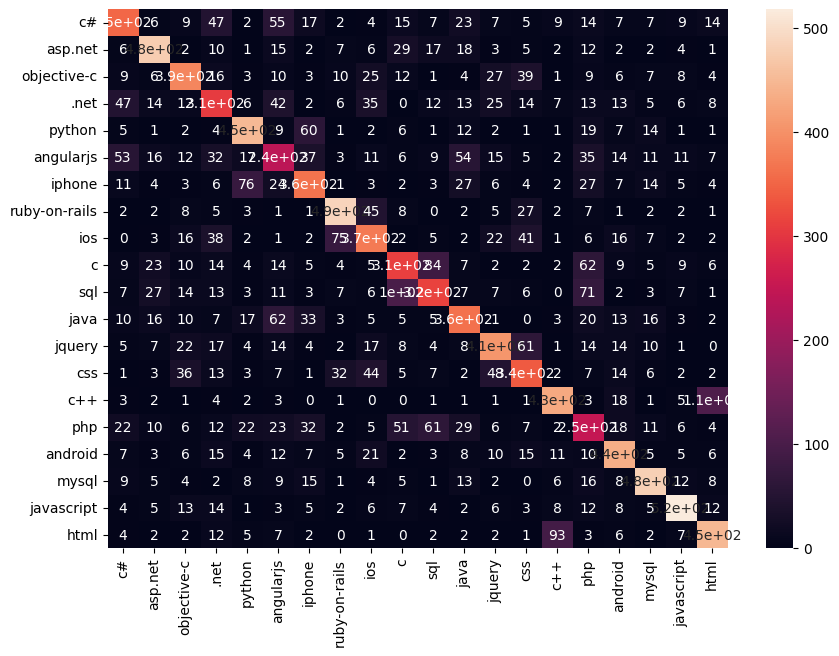

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# CNN with Word2Vec

scaler = MinMaxScaler()
scaler.fit(X_train_word_average)
X_train_word_average_scaled = scaler.transform(X_train_word_average)

labelencoder = OneHotEncoder()
y_train_encoded = labelencoder.fit_transform(y_train.values.reshape(-1, 1))


X_train_word_average_scaled_repeated = np.repeat(X_train_word_average_scaled[:,:,np.newaxis], axis = 2, repeats = 20)

cnn2 = create_cnn2()
cnn2.fit(np.asarray(train_tokenized), y_train_encoded.toarray())

embedding_model = wv
embedding_weights = [np.array([embedding_model[w] if w in embedding_model
                                   else np.random.uniform(-0.25, 0.25, embedding_model.vector_size)
                                   for w in range(0, count_words_in_a_dataset(df))])]

In [19]:
from tensorflow.keras.layers import Embedding
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.
    Parameters    ----------    train_embeddings : bool
    If False, the returned weights are frozen and stopped from being updated.
    If True, the weights can / will be further updated in Keras.
    Returns    -------    `keras.layers.Embedding`
    Embedding layer, to be used as input to deeper network layers.    """
    keyed_vectors = model  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array
    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer



In [26]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)


def create_cnn2():
    textcnnmodel = Sequential()



    embedding_layer = gensim_to_keras_embedding(wv)
    #layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])


    textcnnmodel.add(embedding_layer)
    textcnnmodel.add(SpatialDropout1D(0.2))
    textcnnmodel.add(layers.Conv1D(200, 20, padding="valid", activation='relu'))
    textcnnmodel.add(layers.GlobalMaxPooling1D())
    textcnnmodel.add(layers.Dense(20, activation='softmax'))
    textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    textcnnmodel.summary()

    return textcnnmodel

Found 247039 unique tokens.
Shape of data tensor: (40000, 250)
Shape of label tensor: (40000, 20)


In [21]:
cnn2 = create_cnn2()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     900,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 900,000,000 (3.35 GB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 900,000,000 (3.35 GB)

In [22]:
epochs = 5
batch_size = 64
start_time = time.perf_counter()
history = cnn2.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 143s 361ms/step - accuracy: 0.2371 - loss: 0.2041 - val_accuracy: 0.6179 - val_loss: 0.1149
Epoch 2/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 350ms/step - accuracy: 0.7044 - loss: 0.0956 - val_accuracy: 0.6854 - val_loss: 0.0898
Epoch 3/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.8193 - loss: 0.0634 - val_accuracy: 0.6882 - val_loss: 0.0839
Epoch 4/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 141s 357ms/step - accuracy: 0.9018 - loss: 0.0447 - val_accuracy: 0.7079 - val_loss: 0.0812
Epoch 5/5
394/394 ━━━━━━━━━━━━━━━━━━━━ 136s 346ms/step - accuracy: 0.9566 - loss: 0.0300 - val_accuracy: 0.6975 - val_loss: 0.0828
The model took 696.6960826390423 seconds to train on 28000 items. Avg inference time was 0.024882002951394366


In [27]:
start_time = time.perf_counter()
y_pred = cnn2.predict(X_test)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

y_pred=np.argmax(y_pred, axis=1)
Y_test=np.argmax(Y_test, axis=1)


print('accuracy %s' % accuracy_score(y_pred, Y_test))
print(classification_report(Y_test, y_pred, target_names=classes))

375/375 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step
The model took 25.11873568012379 seconds to predidct 12000 items. Avg inference time was 0.002093227973343649
accuracy 0.7178333333333333
               precision    recall  f1-score   support

           c#       0.54      0.65      0.59       613
      asp.net       0.80      0.81      0.80       620
  objective-c       0.95      0.85      0.90       587
         .net       0.72      0.70      0.71       586
       python       0.80      0.67      0.73       599
    angularjs       0.50      0.47      0.49       589
       iphone       0.53      0.69      0.60       594
ruby-on-rails       0.70      0.85      0.77       610
          ios       0.65      0.60      0.62       617
            c       0.57      0.63      0.60       587
          sql       0.65      0.58      0.62       611
         java       0.77      0.74      0.76       594
       jquery       0.69      0.79      0.74       619
          css       0.84      0.80      0.82    

<Axes: >

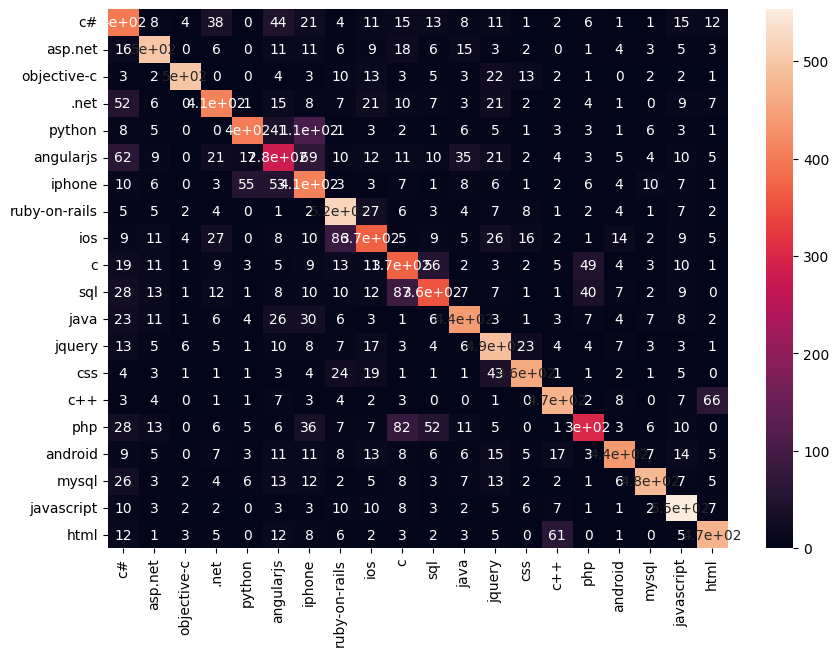

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(Y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# LSTM with Word2Vec

In [ ]:
def create_lstm2():
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=300))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], )
    model.build(input_shape=(None,300))
    model.summary()

    return model

lstm2 = create_lstm2()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, 300, 100)            │       5,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_14                 │ (None, 300, 100)            │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 100)                 │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 20)                  │           2,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,082,420 (19.39 MB)

 Trainable params: 5,082,420 (19.39 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_word_average.shape, Y_train.shape, X_test_word_average.shape

((28000, 300), (28000, 20), (12000, 300))

In [ ]:
Y_train[2]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False])

In [ ]:
epochs = 10
batch_size = 64
start_time = time.perf_counter()
history = lstm2.fit(X_train_word_average, Y_train, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/10
372/394 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.0485 - loss: 2.9976

KeyboardInterrupt: 

375/375 ━━━━━━━━━━━━━━━━━━━━ 34s 89ms/step
The model took 33.74011769797653 seconds to predidct 12000 items. Avg inference time was 0.0028116764748313773
accuracy 0.04783333333333333


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

           c#       0.00      0.00      0.00         0
      asp.net       0.00      0.00      0.00         0
  objective-c       0.00      0.00      0.00         0
         .net       0.00      0.00      0.00         0
       python       0.00      0.00      0.00         0
    angularjs       0.00      0.00      0.00         0
       iphone       0.00      0.00      0.00         0
ruby-on-rails       0.00      0.00      0.00         0
          ios       0.00      0.00      0.00         0
            c       0.00      0.00      0.00         0
          sql       0.00      0.00      0.00         0
         java       0.00      0.00      0.00         0
       jquery       0.00      0.00      0.00         0
          css       1.00      0.05      0.09     12000
          c++       0.00      0.00      0.00         0
          php       0.00      0.00      0.00         0
      android       0.00      0.00      0.00         0
        m

<Axes: >

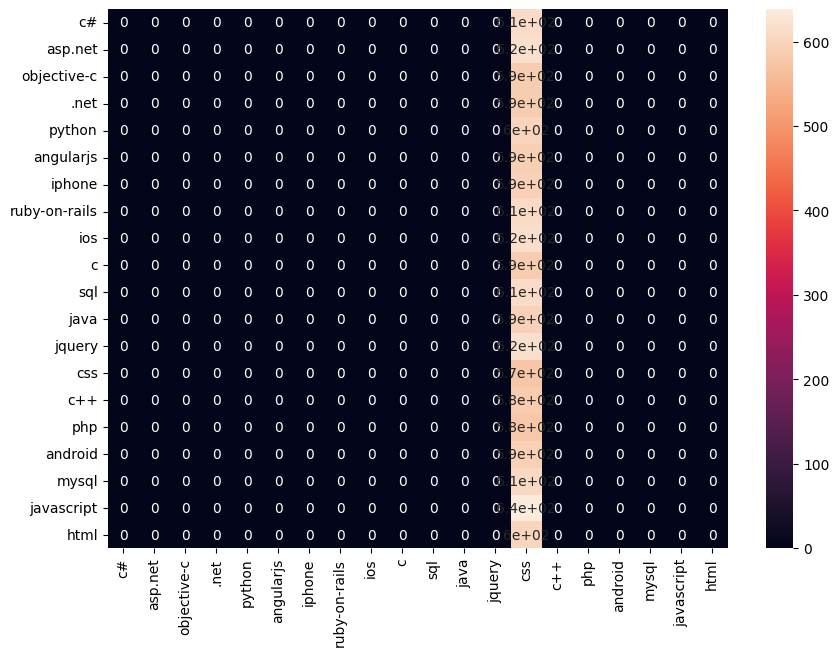

In [ ]:
start_time = time.perf_counter()
y_pred = lstm2.predict(X_test_word_average)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test_word_average)} items. Avg inference time was {elapsed_time/len(X_test_word_average)}")

y_pred_decoded = encoder.inverse_transform(y_pred)


print('accuracy %s' % accuracy_score(y_pred_decoded, y_test))
print(classification_report(y_pred_decoded, y_test, target_names=classes))

from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred_decoded)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
print(y_pred[:10])

[[0.0555647  0.03070558 0.04136667 0.02742448 0.06195033 0.0444639
  0.04905723 0.05474506 0.04711148 0.04313176 0.05364516 0.03145589
  0.05964841 0.07417144 0.05539642 0.0325035  0.04713518 0.07180921
  0.06049776 0.05821588]
 [0.0555647  0.03070558 0.04136667 0.02742448 0.06195033 0.0444639
  0.04905723 0.05474506 0.04711148 0.04313176 0.05364516 0.03145589
  0.05964841 0.07417144 0.05539642 0.0325035  0.04713518 0.07180921
  0.06049776 0.05821588]
 [0.0555647  0.03070558 0.04136667 0.02742448 0.06195033 0.0444639
  0.04905723 0.05474506 0.04711148 0.04313176 0.05364516 0.03145589
  0.05964841 0.07417144 0.05539642 0.0325035  0.04713518 0.07180921
  0.06049776 0.05821588]
 [0.0555647  0.03070558 0.04136667 0.02742448 0.06195033 0.0444639
  0.04905723 0.05474506 0.04711148 0.04313176 0.05364516 0.03145589
  0.05964841 0.07417144 0.05539642 0.0325035  0.04713518 0.07180921
  0.06049776 0.05821588]
 [0.0555647  0.03070558 0.04136667 0.02742448 0.06195033 0.0444639
  0.04905723 0.054745

# Doc2Vec

In [ ]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re

def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled
X_train, X_test, y_train, y_test = train_test_split(df.post, df.tags, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [ ]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

start_time = time.perf_counter()
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The DOC2VEC model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


100%|██████████| 40000/40000 [00:00<00:00, 2496720.98it/s]


The DOC2VEC model took 136.88031199993566 seconds to train on 28000 items. Avg inference time was 0.004888582571426273


In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.dv[prefix]
    return vectors

train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

# NaiveBayes with Doc2vec

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler



nb2 =  Pipeline([('Normalizing',MinMaxScaler()),('MultinomialNB',MultinomialNB())])
start_time = time.perf_counter()
nb2.fit(train_vectors_dbow, y_train)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


from sklearn.metrics import classification_report
start_time = time.perf_counter()
y_pred = nb2.predict(test_vectors_dbow)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes))

The model took 0.13090108893811703 seconds to train on 28000 items. Avg inference time was 4.675038890647037e-06
The model took 0.03098244685679674 seconds to predidct 12000 items. Avg inference time was 2.5818705713997283e-06
accuracy 0.7611666666666667
               precision    recall  f1-score   support

           c#       0.47      0.73      0.57       589
      asp.net       0.97      0.75      0.85       661
  objective-c       0.97      0.90      0.93       606
         .net       0.78      0.65      0.71       613
       python       0.83      0.86      0.84       601
    angularjs       0.66      0.65      0.66       585
       iphone       0.87      0.73      0.79       621
ruby-on-rails       0.78      0.81      0.80       587
          ios       0.56      0.74      0.64       560
            c       0.67      0.53      0.59       611
          sql       0.56      0.66      0.61       593
         java       0.81      0.80      0.80       581
       jquery       0.81     

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Logistic Regression with Doc2vec

In [ ]:
logreg2 = LogisticRegression(n_jobs=1, C=1e5,max_iter=1000)
#logreg2.fit(train_vectors_dbow, y_train)
start_time = time.perf_counter()
logreg2 = logreg2.fit(train_vectors_dbow, y_train)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


start_time = time.perf_counter()
y_pred = logreg2.predict(test_vectors_dbow)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")


print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes))

The model took 10.534562523011118 seconds to train on 28000 items. Avg inference time was 0.0003762343758218257
The model took 0.0069621040020138025 seconds to predidct 12000 items. Avg inference time was 5.801753335011502e-07
accuracy 0.7958333333333333
               precision    recall  f1-score   support

           c#       0.66      0.65      0.66       589
      asp.net       0.87      0.90      0.88       661
  objective-c       0.93      0.93      0.93       606
         .net       0.78      0.76      0.77       613
       python       0.85      0.87      0.86       601
    angularjs       0.72      0.70      0.71       585
       iphone       0.84      0.82      0.83       621
ruby-on-rails       0.83      0.83      0.83       587
          ios       0.69      0.67      0.68       560
            c       0.67      0.64      0.66       611
          sql       0.66      0.67      0.66       593
         java       0.79      0.84      0.81       581
       jquery       0.78     

<Axes: >

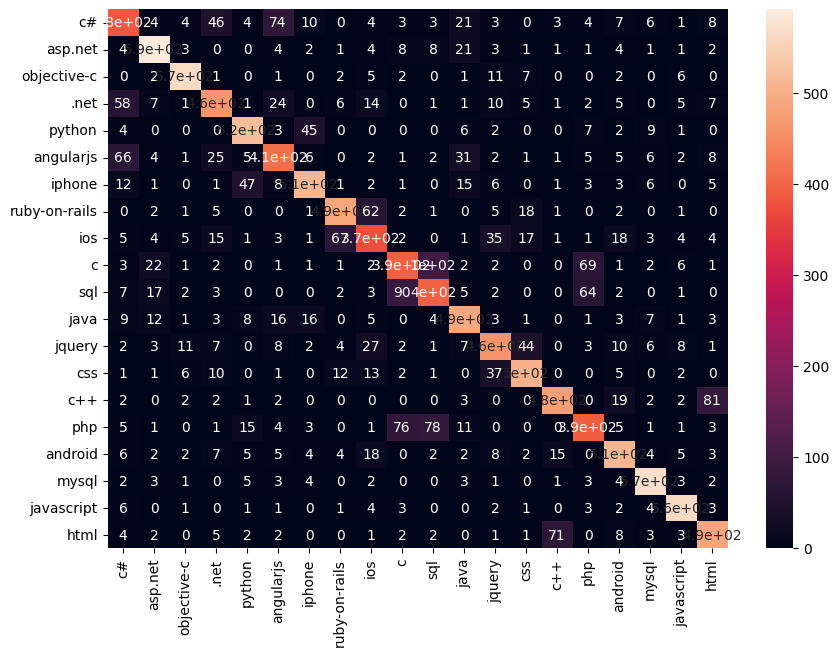

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# CNN with Doc2Vec

In [ ]:
def create_cnn3():
    textcnnmodel = Sequential()
    textcnnmodel.add(layers.Conv1D(200, 20, activation='relu', input_shape=(300, 1)))
    textcnnmodel.add(layers.GlobalMaxPooling1D())
    textcnnmodel.add(layers.Dense(20, activation='softmax'))
    textcnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return textcnnmodel

cnn3 = create_cnn3()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1))

In [ ]:
start_time = time.perf_counter()
history_cnn3 = cnn3.fit(train_vectors_dbow, y_train_encoded.toarray(), epochs=10, batch_size=50,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.0607 - loss: 0.2740 - val_accuracy: 0.0761 - val_loss: 0.2001
Epoch 2/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.1039 - loss: 0.1989 - val_accuracy: 0.1411 - val_loss: 0.1952
Epoch 3/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.1653 - loss: 0.1936 - val_accuracy: 0.1993 - val_loss: 0.1885
Epoch 4/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.2123 - loss: 0.1860 - val_accuracy: 0.2204 - val_loss: 0.1809
Epoch 5/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2511 - loss: 0.1776 - val_accuracy: 0.2404 - val_loss: 0.1744
Epoch 6/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.2826 - loss: 0.1707 - val_accuracy: 0.2861 - val_loss: 0.1684
Epoch 7/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.3068 - loss: 0.1650 - val_accuracy: 0.3100 - val_loss: 0.1639
Epoch 8/10
504/504 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.3301 - loss: 0.1606 - val_ac

In [ ]:
start_time = time.perf_counter()
y_pred = cnn3.predict(test_vectors_dbow)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

#y_pred = np.argmax(y_pred, axis=1)
y_pred_decoded = encoder.inverse_transform(y_pred)


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
The model took 2.0131063528824598 seconds to predidct 12000 items. Avg inference time was 0.000167758862740205


In [ ]:
print('accuracy %s' % accuracy_score(y_pred_decoded, y_test))
print(classification_report(y_pred_decoded, y_test, target_names=classes))

accuracy 0.35591666666666666
               precision    recall  f1-score   support

           c#       0.26      0.40      0.32       384
      asp.net       0.13      0.57      0.21       149
  objective-c       0.44      0.51      0.47       517
         .net       0.46      0.35      0.40       812
       python       0.28      0.51      0.36       330
    angularjs       0.23      0.24      0.24       563
       iphone       0.43      0.31      0.36       884
ruby-on-rails       0.61      0.45      0.52       793
          ios       0.41      0.26      0.32       861
            c       0.04      0.45      0.08        55
          sql       0.69      0.26      0.38      1577
         java       0.29      0.30      0.29       562
       jquery       0.11      0.39      0.17       174
          css       0.35      0.41      0.38       508
          c++       0.21      0.46      0.29       275
          php       0.24      0.36      0.29       400
      android       0.30      0.35 

<Axes: >

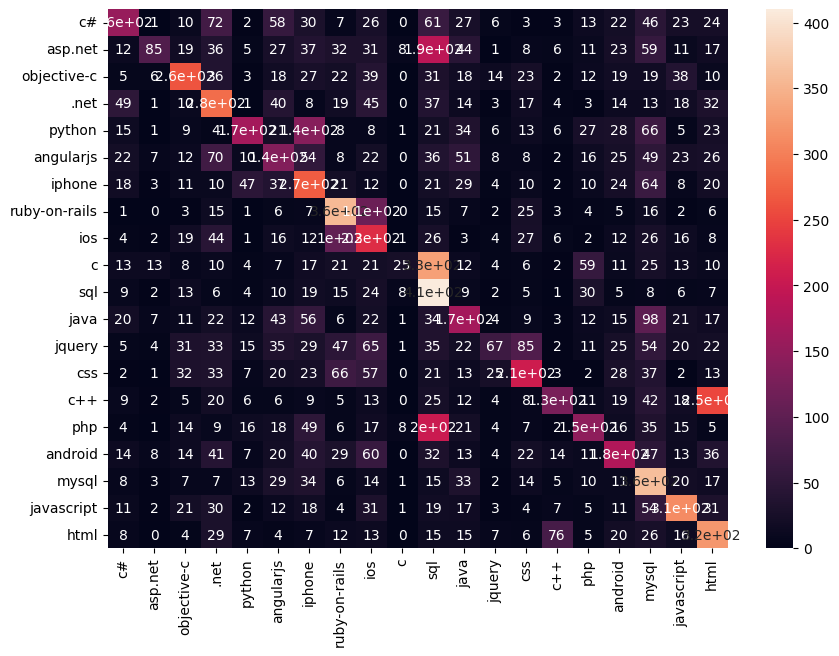

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred_decoded)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# LSTM with Doc2Vec

In [ ]:
def create_lstm3():
    model = Sequential()

    model.add(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2, input_shape=(300, 1)))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

lstm3 = create_lstm3()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 20)                  │           2,020 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,820 (167.27 KB)

 Trainable params: 42,820 (167.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start_time = time.perf_counter()
history_lstm3 = lstm3.fit(train_vectors_dbow, y_train_encoded.toarray(), epochs=100, batch_size=100,
                   validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch 1/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 89s 346ms/step - accuracy: 0.0730 - loss: 2.9580 - val_accuracy: 0.1189 - val_loss: 2.8772
Epoch 2/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 95s 377ms/step - accuracy: 0.0990 - loss: 2.8974 - val_accuracy: 0.1221 - val_loss: 2.8421
Epoch 3/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 96s 379ms/step - accuracy: 0.1100 - loss: 2.8663 - val_accuracy: 0.1364 - val_loss: 2.8063
Epoch 4/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 369ms/step - accuracy: 0.1234 - loss: 2.8386 - val_accuracy: 0.1596 - val_loss: 2.7692
Epoch 5/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 89s 353ms/step - accuracy: 0.1291 - loss: 2.8260 - val_accuracy: 0.1618 - val_loss: 2.7460
Epoch 6/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 91s 361ms/step - accuracy: 0.1379 - loss: 2.7986 - val_accuracy: 0.1632 - val_loss: 2.7454
Epoch 7/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 91s 362ms/step - accuracy: 0.1343 - loss: 2.7923 - val_accuracy: 0.1779 - val_loss: 2.7162
Epoch 8/100
252/252 ━━━━━━━━━━━━━━━━━━━━ 93s 368ms/step - accuracy: 0.1452 -

In [ ]:
start_time = time.perf_counter()
y_pred = lstm3.predict(test_vectors_dbow)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"The model took {elapsed_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

y_pred_decoded = encoder.inverse_transform(y_pred)


print('accuracy %s' % accuracy_score(y_pred_decoded, y_test))
print(classification_report(y_pred_decoded, y_test, target_names=classes))



375/375 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step
The model took 27.215853293891996 seconds to predidct 12000 items. Avg inference time was 0.0022679877744909995
accuracy 0.33516666666666667
               precision    recall  f1-score   support

           c#       0.39      0.27      0.32       844
      asp.net       0.21      0.54      0.30       250
  objective-c       0.31      0.53      0.39       357
         .net       0.28      0.36      0.31       477
       python       0.51      0.35      0.41       868
    angularjs       0.16      0.32      0.22       293
       iphone       0.39      0.30      0.34       811
ruby-on-rails       0.53      0.40      0.46       783
          ios       0.29      0.23      0.26       711
            c       0.12      0.28      0.17       257
          sql       0.47      0.23      0.31      1185
         java       0.41      0.40      0.41       594
       jquery       0.22      0.32      0.26       427
          css       0.32      0.33      0.32 

<Axes: >

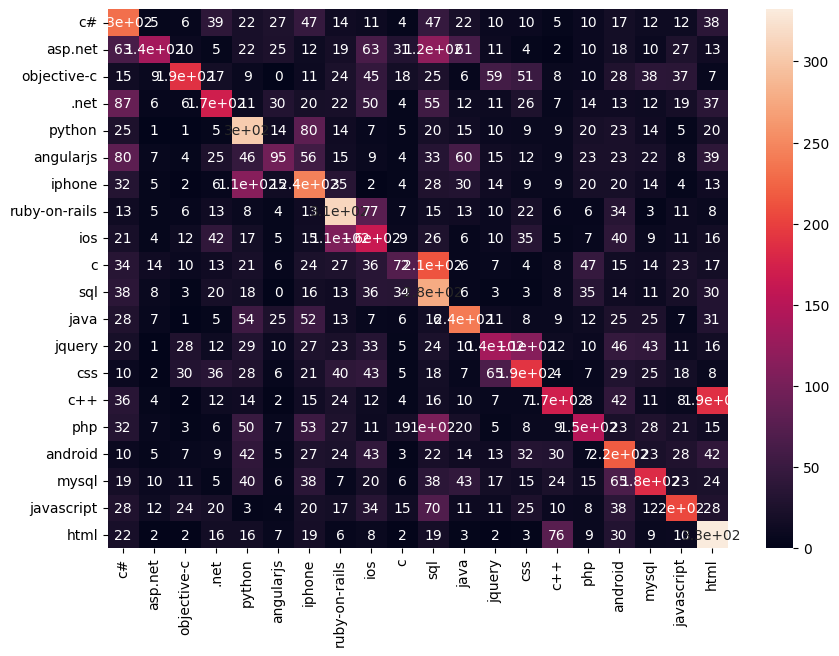

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(y_test,y_pred_decoded)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

# Transformer Encoder

In [ ]:
#REMEMBER to run dataload for standard tokenization before (this section is below Word2Vec and Doc2Vec)!
X_train.shape, y_train.shape, y_test.shape


AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import torch
import torch.nn as nn

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Create a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        # Return the number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the data and label at the specified index
        data = self.data[idx]
        label = self.labels[idx]
        return data, label



In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['tags']).values
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)

Found 247039 unique tokens.
Shape of data tensor: (40000, 250)
Shape of label tensor: (40000, 20)


In [ ]:
Y_train = Y_train.astype(float)
Y_test = Y_test.astype(float)

In [ ]:
# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(X_train)   # Replace `...` with your data
labels_array = torch.tensor(Y_train) # Replace `...` with your labels

# Step 2: Instantiate the dataset
dataset = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in dataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;

# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(X_test)   # Replace `...` with your data
labels_array = torch.tensor(Y_test) # Replace `...` with your labels

# Step 2: Instantiate the dataset
testdataset = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
testdataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in testdataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;
num_classes = len(classes)
num_classes

20

In [ ]:
# @title Transformer (nn.model)
class Transformer(nn.Module):

  def __init__(self, device,num_words, num_classes, embeddingSize = 128, seqLen = 255, ):

    super(Transformer, self).__init__()
    self.class_num = num_classes

    self.embed = nn.Embedding(num_embeddings=num_words, embedding_dim=embeddingSize)
    self.embed.weight.requires_grad = True

    #lerneable parameter
    self.embedClass = nn.Parameter(data=torch.randn(1, 1, embeddingSize),requires_grad=True)
    #positional embedding
    self.embedPosition  = nn.Parameter(data=torch.randn(1, seqLen+1, embeddingSize),requires_grad=True)

    self.transformer = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
        d_model = embeddingSize,
        nhead = 5,
        dim_feedforward=1024,
        dropout=0.1,
        activation="gelu",
        device=device,
        dtype=torch.float,
        batch_first=True,
    ), num_layers = 1, norm=None, enable_nested_tensor=True, mask_check=False)

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embeddingSize),
        nn.Linear(in_features= embeddingSize,
                  out_features=self.class_num)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    x = self.embed(x[:,:])

    class_token = self.embedClass.expand(batch_size, -1, -1)#.cuda() # "-1" means to infer the dimension (try this line on its own)
    x = torch.cat((class_token, x), dim=1)

    x = self.embedPosition + x

    x = self.transformer(x)

    x = self.classifier(x[:,0])
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
model = Transformer(device,len(tokenizer.word_index),num_classes,EMBEDDING_DIM,MAX_SEQUENCE_LENGTH)
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.005)

loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:
total_train_time = 0
for i in range(250):
  train_loss, train_acc = 0, 0
  j = 0
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    start_time = time.perf_counter()
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_train_time += elapsed_time

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    #print(y_pred_class,torch.argmax(y,dim=1))
    train_acc += (y_pred_class == torch.argmax(y,dim=1)).sum().item()/len(y_pred)
    j = j + 1
    if (j%100==0):
      print(f"Epoch: {i} out of {100} - Batch {j} out of {len(dataloader)}")

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  print(f"Loss: {train_loss}, Accuracy: {train_acc}")
print(f"The model took {total_train_time} seconds to train on {len(X_train)} items. Avg inference time was {elapsed_time/len(X_train)}")


Epoch: 0 out of 100 - Batch 100 out of 875
Epoch: 0 out of 100 - Batch 200 out of 875
Epoch: 0 out of 100 - Batch 300 out of 875
Epoch: 0 out of 100 - Batch 400 out of 875
Epoch: 0 out of 100 - Batch 500 out of 875
Epoch: 0 out of 100 - Batch 600 out of 875
Epoch: 0 out of 100 - Batch 700 out of 875
Epoch: 0 out of 100 - Batch 800 out of 875
Loss: 2.6788934039832926, Accuracy: 0.15282142857142858
Epoch: 1 out of 100 - Batch 100 out of 875
Epoch: 1 out of 100 - Batch 200 out of 875
Epoch: 1 out of 100 - Batch 300 out of 875
Epoch: 1 out of 100 - Batch 400 out of 875
Epoch: 1 out of 100 - Batch 500 out of 875
Epoch: 1 out of 100 - Batch 600 out of 875
Epoch: 1 out of 100 - Batch 700 out of 875
Epoch: 1 out of 100 - Batch 800 out of 875
Loss: 2.184012338695765, Accuracy: 0.30314285714285716
Epoch: 2 out of 100 - Batch 100 out of 875
Epoch: 2 out of 100 - Batch 200 out of 875
Epoch: 2 out of 100 - Batch 300 out of 875
Epoch: 2 out of 100 - Batch 400 out of 875
Epoch: 2 out of 100 - Batch 5

In [ ]:
y_pred_transformerEncoder = []
y_reals_transformerEncoder = []
with torch.inference_mode():
  test_loss, test_acc = 0, 0
  total_time = 0.0
  for batch, (X,y) in enumerate(testdataloader):
    X,y = X.to(device),y.to(device)
    start_time = time.perf_counter()
    y_pred = model(X)
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    total_time += elapsed_time
    loss = loss_fn(y_pred,y)
    test_loss += loss.item()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    #print(y_pred_class,torch.argmax(y,dim=1))
    test_acc += (y_pred_class == torch.argmax(y,dim=1)).sum().item()/len(y_pred)
    for item in y_pred_class:
      y_pred_transformerEncoder.append(item)
    for item in torch.argmax(y,dim=1):
      y_reals_transformerEncoder.append(item)
  test_loss = test_loss / len(testdataloader)
  test_acc = test_acc / len(testdataloader)
  print(f"Loss: {test_loss}, Accuracy: {test_acc}")
  print(f"The model took {total_time} seconds to predidct {len(X_test)} items. Avg inference time was {elapsed_time/len(X_test)}")

# Adjust metrics to get average loss and accuracy per batch
test_loss = test_loss / len(testdataloader)
test_acc = test_acc / len(testdataloader)


NameError: name 'model' is not defined

In [ ]:
model

In [ ]:
y_pred=[f.to('cpu') for f in y_pred_transformerEncoder]
Y_test_reals=[f.to('cpu') for f in y_reals_transformerEncoder]

print('accuracy %s' % accuracy_score(y_pred, Y_test_reals))
print(classification_report(Y_test_reals, y_pred, target_names=classes))

accuracy 0.9499642857142857
               precision    recall  f1-score   support

           c#       0.93      0.95      0.94      1387
      asp.net       0.97      0.96      0.97      1380
  objective-c       1.00      0.98      0.99      1413
         .net       0.97      0.93      0.95      1414
       python       0.97      0.95      0.96      1401
    angularjs       0.90      0.93      0.91      1411
       iphone       0.98      0.94      0.96      1406
ruby-on-rails       0.95      0.96      0.95      1390
          ios       0.95      0.90      0.92      1383
            c       0.97      0.92      0.94      1413
          sql       0.90      0.96      0.93      1389
         java       0.96      0.95      0.96      1406
       jquery       0.93      0.95      0.94      1381
          css       0.89      0.97      0.93      1426
          c++       0.96      0.97      0.97      1416
          php       0.93      0.94      0.94      1422
      android       0.95      0.96  

<Axes: >

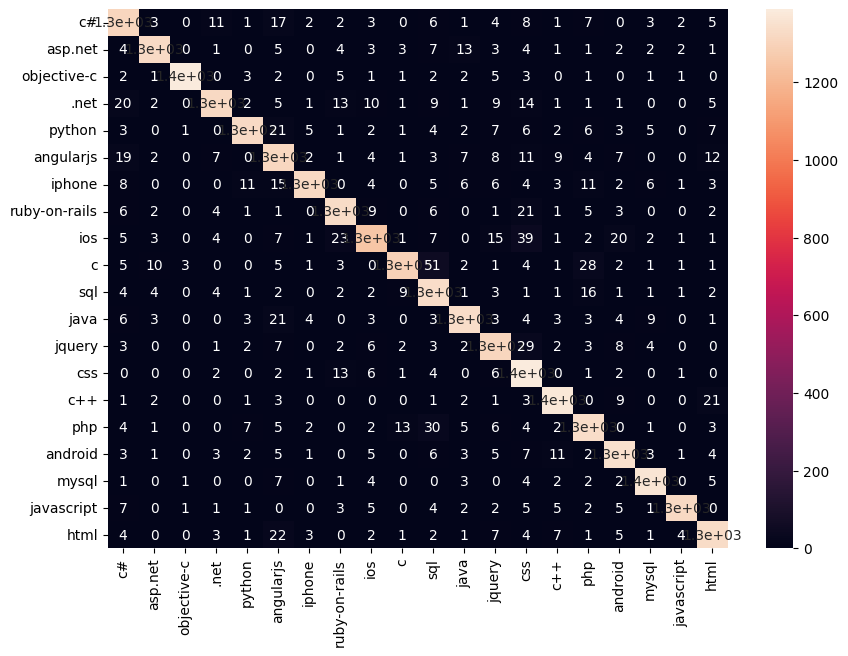

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

array=confusion_matrix(Y_test_reals,y_pred)
df_cm = pd.DataFrame(array, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
# @title Cleanup
# Due to Python memory management this might be needed to clean gpu cache (even a few times)
# Please ignore error 'model' is not defined
import torch
#gc.collect()
torch.cuda.empty_cache()
#!nvidia-smi #prints out stats

del model

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
import gc

In [ ]:
!nvidia-smi

Sat Mar 29 19:07:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070        Off |   00000000:42:00.0 Off |                  N/A |
|  0%   50C    P8             17W /  240W |    5920MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Transformer Encoder - Word2Vec

In [ ]:
from gensim.models import Word2Vec
wv = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)


wv.fill_norms()
from itertools import islice
list(islice(wv.key_to_index, 60, 70))

['than', 'when', 'We', 'over', 'last', 'new', 'other', 'her', 'people', 'into']

In [ ]:
def word_averaging(wv, words):
    all_words, mean = set(), []

    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.key_to_index:
            mean.append(wv.vectors[wv.key_to_index[word]])
            all_words.add(wv.key_to_index[word])

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)

        return np.zeros((250,300))

    mean = gensim.matutils.unitvec(np.array(mean)).astype(np.float32)
    current_rows, cols = mean.shape
    padding_rows = 250 - current_rows #250 represents the mas seq len
    if padding_rows > 0:
      padding = np.full((padding_rows, cols), 0)

      extended_arr = np.vstack([mean, padding])  # Stack original and padding
      return extended_arr

    else:
      return mean[:250] #250 represents the mas seq len

def word_list(wv, text_list):
    return [word_averaging(wv, post) for post in text_list ]

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens


In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['post']), axis=1).values


In [ ]:
X_train_word = word_list(wv,train_tokenized)


In [ ]:
X_test_word = word_list(wv,test_tokenized)

In [ ]:
np.max(X_train_word[0])

0.03646901994943619

In [ ]:
# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(X_train_word)   # Replace `...` with your data
labels_array = torch.tensor(Y_train) # Replace `...` with your labels

# Step 2: Instantiate the dataset
dataset = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in dataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;



In [ ]:
goodshape = X_test_word[0].shape
for item in X_test_word:
  if item.shape != goodshape:
    print(item.shape)

In [ ]:
# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(X_test_word)   # Replace `...` with your data
labels_array = torch.tensor(Y_test) # Replace `...` with your labels

# Step 2: Instantiate the dataset
testdataset_word = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
testdataloader_word = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in testdataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;
num_classes = len(classes)
num_classes

20

In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=250):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


In [ ]:
# @title Transformer (nn.model)
class Transformer(nn.Module):

  def __init__(self, device,num_words, num_classes, embeddingSize = 128, seqLen = 255, ):

    super(Transformer, self).__init__()
    self.class_num = num_classes

    #self.embed = nn.Embedding(num_embeddings=num_words, embedding_dim=embeddingSize)
    #self.embed.weight.requires_grad = True

    #lerneable parameter
    self.embedClass = nn.Parameter(data=torch.randn(1, 1, embeddingSize),requires_grad=True)
    #positional embedding
    #self.embedPosition  = nn.Parameter(data=torch.randn(1, seqLen+num_classes, embeddingSize),requires_grad=True)

    self.pe = PositionalEncoding(d_model=embeddingSize,max_len=270)

    self.transformer = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
        d_model = embeddingSize,
        nhead = 20,
        dim_feedforward=2048,
        dropout=0.1,
        activation="gelu",
        device=device,
        dtype=torch.float,
        batch_first=True,
    ), num_layers = 4, norm=None, enable_nested_tensor=True, mask_check=False)

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embeddingSize),
        nn.Linear(in_features= embeddingSize,
                  out_features=self.class_num)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    x = x.float()
    x = torch.nn.functional.normalize(x, p=2, dim=-1)
    #x = self.embed(x[:,:])

    class_token = self.embedClass.expand(batch_size, -1, -1).to(x.device) # "-1" means to infer the dimension (try this line on its own)
    #print(x.shape, class_token.shape)
    x = torch.cat((class_token, x), dim=1)

    x = self.pe(x)

    x = self.transformer(x)

    x = self.classifier(x[:,0])
    #print(x,x.shape)
    return x

In [ ]:
# @title Transformer (nn.model)
class Transformer(nn.Module):

  def __init__(self, device,num_words, num_classes, embeddingSize = 128, seqLen = 255, ):

    super(Transformer, self).__init__()
    self.class_num = num_classes

    self.embed = nn.Embedding(num_embeddings=num_words, embedding_dim=embeddingSize)
    self.embed.weight.requires_grad = True

    #lerneable parameter
    self.embedClass = nn.Parameter(data=torch.randn(1, 1, embeddingSize),requires_grad=True)
    #positional embedding
    self.embedPosition  = nn.Parameter(data=torch.randn(1, seqLen+1, embeddingSize),requires_grad=True)

    self.transformer = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
        d_model = embeddingSize,
        nhead = 5,
        dim_feedforward=1024,
        dropout=0.1,
        activation="gelu",
        device=device,
        dtype=torch.double,
        batch_first=True,
    ), num_layers = 1, norm=None, enable_nested_tensor=True, mask_check=False)

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embeddingSize,dtype=torch.double),
        nn.Linear(in_features= embeddingSize,
                  out_features=self.class_num,dtype=torch.double)
    )

  def forward(self, x):
    batch_size = x.shape[0]

    #x = self.embed(x[:,:])

    class_token = self.embedClass.expand(batch_size, -1, -1).cuda() # "-1" means to infer the dimension (try this line on its own)
    x = torch.cat((class_token, x), dim=1)

    x = self.embedPosition + x

    x = self.transformer(x)

    x = self.classifier(x[:,0])
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

model = Transformer(device,len(tokenizer.word_index),num_classes,300,MAX_SEQUENCE_LENGTH)
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.005)

loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
for i in range(100):
  train_loss, train_acc = 0, 0
  j = 0
  for batch, (X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    #for name, param in model.named_parameters():
    #  if param.grad is not None:
    #    print(name, param.grad.norm().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    #print(y_pred_class,torch.argmax(y,dim=1))
    train_acc += (y_pred_class == torch.argmax(y,dim=1)).sum().item()/len(y_pred)
    j = j + 1
    if (j%100==0):
      print(f"Epoch: {i} out of {100} - Batch {j} out of {len(dataloader)}")

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  print(f"Loss: {train_loss}, Accuracy: {train_acc}")

Epoch: 0 out of 100 - Batch 100 out of 875
Epoch: 0 out of 100 - Batch 200 out of 875
Epoch: 0 out of 100 - Batch 300 out of 875
Epoch: 0 out of 100 - Batch 400 out of 875
Epoch: 0 out of 100 - Batch 500 out of 875
Epoch: 0 out of 100 - Batch 600 out of 875
Epoch: 0 out of 100 - Batch 700 out of 875
Epoch: 0 out of 100 - Batch 800 out of 875
Loss: 3.048137300784039, Accuracy: 0.04960714285714286
Epoch: 1 out of 100 - Batch 100 out of 875
Epoch: 1 out of 100 - Batch 200 out of 875
Epoch: 1 out of 100 - Batch 300 out of 875
Epoch: 1 out of 100 - Batch 400 out of 875
Epoch: 1 out of 100 - Batch 500 out of 875
Epoch: 1 out of 100 - Batch 600 out of 875
Epoch: 1 out of 100 - Batch 700 out of 875
Epoch: 1 out of 100 - Batch 800 out of 875
Loss: 3.0015338984723505, Accuracy: 0.04792857142857143
Epoch: 2 out of 100 - Batch 100 out of 875
Epoch: 2 out of 100 - Batch 200 out of 875
Epoch: 2 out of 100 - Batch 300 out of 875
Epoch: 2 out of 100 - Batch 400 out of 875
Epoch: 2 out of 100 - Batch 5

# Transformer Encoder - Doc2Vec

In [ ]:
#REMEMBER to run dataload for standard tokenization before (this section is below Word2Vec and Doc2Vec)!
train_vectors_dbow.shape, y_train.shape, y_test.shape, test_vectors_dbow.shape


((28000, 300), (28000,), (12000,), (12000, 300))

In [ ]:
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_encoded = encoder.fit_transform(y_test.values.reshape(-1, 1)).toarray()

In [ ]:
train_vectors_dbow[0]

array([ 0.20866218,  0.64051157, -0.49839741, -0.87613374, -0.02583099,
       -0.2033492 , -0.21966319,  0.84969008, -0.41752306,  0.37383267,
        0.22523069,  0.6752277 , -0.78705394,  0.09642875, -0.16114819,
       -0.03756433,  0.4491294 ,  0.28059599,  0.14305916,  0.26921725,
        0.60307211,  0.05347421, -0.07607248,  0.67275023, -0.04608052,
       -0.01217718,  0.0891403 ,  0.00172459, -0.33330598,  0.03676758,
       -0.00737015,  0.16908039,  0.1735516 ,  0.26704553, -0.51482677,
       -0.17153838, -0.27875054, -0.8891198 , -0.28691044, -0.91143364,
        0.48026869,  0.65392888, -0.29207397, -0.29201457, -0.23560977,
        0.63463694,  0.51252508, -0.16075923, -0.06387133, -0.56157666,
       -0.25884092,  0.1890789 , -1.02199984,  0.04084124,  0.73233563,
        0.38419259, -0.07830393,  1.38043904, -0.3490704 ,  0.42026818,
        0.237056  ,  0.23067619, -0.42920321,  0.11712766, -0.33803794,
        0.83876246, -0.34629238, -0.10952405,  0.08317351,  0.38

In [ ]:
import torch
import torch.nn as nn

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Create a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        # Return the number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Retrieve the data and label at the specified index
        data = self.data[idx]
        label = self.labels[idx]
        return data, label



In [ ]:
# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(train_vectors_dbow)   # Replace `...` with your data
labels_array = torch.tensor(y_train_encoded) # Replace `...` with your labels

# Step 2: Instantiate the dataset
dataset = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in dataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;

# Assuming `data_array` and `labels_array` are your data and labels
data_array = torch.tensor(test_vectors_dbow)   # Replace `...` with your data
labels_array = torch.tensor(y_test_encoded) # Replace `...` with your labels

# Step 2: Instantiate the dataset
testdataset = CustomDataset(data_array, labels_array)

# Step 3: Create the DataLoader
testdataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the dataloader
#for batch_data, batch_labels in testdataloader:
#    print("Data batch:", batch_data)
#    print("Labels batch:", batch_labels)
#    break;
num_classes = len(classes)
num_classes

20

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

20

In [ ]:
# @title Transformer (nn.model)
class Transformer(nn.Module):

  def __init__(self, device, num_classes, embeddingSize = 128, seqLen = 255, ):

    super(Transformer, self).__init__()
    self.class_num = num_classes

    #self.embed = nn.Embedding(num_embeddings=num_words, embedding_dim=embeddingSize)
    #self.embed.weight.requires_grad = True

    #lerneable parameter
    self.embedClass = nn.Parameter(data=torch.randn(1, 1, embeddingSize),requires_grad=True)
    #positional embedding
    self.embedPosition  = nn.Parameter(data=torch.randn(1, seqLen+1, embeddingSize),requires_grad=True)

    self.transformer = nn.TransformerEncoder(encoder_layer = nn.TransformerEncoderLayer(
        d_model = embeddingSize,
        nhead = 5,
        dim_feedforward=1024,
        dropout=0.1,
        activation="gelu",
        device=device,
        dtype=torch.double,
        batch_first=True,
    ), num_layers = 1, norm=None, enable_nested_tensor=True, mask_check=False)

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embeddingSize,dtype=torch.double),
        nn.Linear(in_features= embeddingSize,
                  out_features=self.class_num,dtype=torch.double)
    )

  def forward(self, x):
    batch_size = x.shape[0]
    #x = self.embed(x[:,:])

    class_token = self.embedClass.expand(batch_size, -1, -1).cuda() # "-1" means to infer the dimension (try this line on its own)
    x = torch.cat((class_token, x), dim=1)

    x = self.embedPosition + x

    x = self.transformer(x)

    x = self.classifier(x[:,0])
    return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

model = Transformer(device,num_classes,300,MAX_SEQUENCE_LENGTH)
model.to(device)
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.005)

loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
for i in range(100):
  train_loss, train_acc = 0, 0
  j = 0
  for batch, (X,y) in enumerate(dataloader):
    print(X.shape)
    break
    X,y = X.to(device),y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()
    #for name, param in model.named_parameters():
    #  if param.grad is not None:
    #    print(name, param.grad.norm().item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    #print(y_pred_class,torch.argmax(y,dim=1))
    train_acc += (y_pred_class == torch.argmax(y,dim=1)).sum().item()/len(y_pred)
    j = j + 1
    if (j%100==0):
      print(f"Epoch: {i} out of {100} - Batch {j} out of {len(dataloader)}")
  break
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  print(f"Loss: {train_loss}, Accuracy: {train_acc}")

torch.Size([32, 300])
